# Inferring RNA velocities in the Human embryo glutamatergic neurogenesis

This tutorial shows how cellDancer analyzes RNA velocity. The process includes (1) estimating RNA velocity, (2) deriving cell fates in embedding space, (3) estimating pseudotime, and (4) displaying predicted kinetics rates (transcription, splicing, and degradation rates), spliced mRNA abundance, and unspliced mRNA abundance in embedding space.

Below is the case study for the Human embryo glutamatergic neurogenesis data. For preprocessing, we filter cell outliers based on counts and numbers of genes expressed, filter genes based on number of cells or counts and computes moments for velocity estimation. 1,054 genes with 1,720 cells were selected.

## Import packages

In [1]:
# import packages
import os
import sys
import glob
import pandas as pd
import anndata as ann
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.utilities as cdutil
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

## Load the velocity estimation result of all 1,054 genes

To project the prediction of RNA velocity to vector fields in embedding space and to estimate pseudotime by using all genes, all the 1,054 genes have already been predicted and could be downloaded and unzipped from [HgForebrainGlut_cellDancer_estimation.csv.zip](https://drive.google.com/file/d/TBD). The csv file could be loaded by ```pd.read_csv()```.

In [2]:
# load the prediction result of all genes
cellDancer_df_file = 'data/HgForebrainGlut_cellDancer_estimation_s.csv'
cellDancer_df=pd.read_csv(cellDancer_df_file)

In [3]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,SCAPER,0.377907,0.300250,0.413027,0.319656,0.290919,0.583949,0.605718,0.063386,10X_17_028:AACCATGGTAATCACCx,Neuroblast,-0.162233,2.568855
1,1,SCAPER,0.346111,0.307946,0.385507,0.315725,0.281298,0.585087,0.607075,0.063386,10X_17_028:AACCATGCATACTACGx,Neuroblast,0.388010,2.642608
2,2,SCAPER,0.377427,0.157733,0.431398,0.219263,0.324510,0.573801,0.592829,0.063386,10X_17_028:AAACCTGGTAAAGGAGx,Radial Glia,5.367040,7.357098
3,3,SCAPER,0.450290,0.237188,0.482404,0.296366,0.324551,0.578121,0.598542,0.063386,10X_17_028:AAAGTAGCAAAGTCAAx,Radial Glia,3.537705,9.916307
4,4,SCAPER,0.405460,0.349812,0.429939,0.362193,0.286943,0.586949,0.609536,0.063386,10X_17_028:AAAGCAACAAACGCGAx,Neuroblast,-1.321112,2.327503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812875,1715,PCP4,0.000000,0.017668,0.000006,0.017446,0.000013,0.212723,0.025128,0.061695,10X_17_029:TTTATGCGTTGCGCACx,Radial Glia,3.227375,8.551692
1812876,1716,PCP4,0.000000,0.012055,0.000007,0.011903,0.000013,0.213251,0.025116,0.061695,10X_17_029:TTTGCGCGTTCCGTCTx,Neuroblast,-2.402294,2.295248
1812877,1717,PCP4,0.004955,0.156260,0.004462,0.154773,0.000007,0.200527,0.025388,0.061695,10X_17_029:TTTGGTTGTACCCAATx,Neuron,-7.754744,7.540400
1812878,1718,PCP4,0.000000,0.014440,0.000007,0.014259,0.000013,0.213026,0.025121,0.061695,10X_17_029:TTTCCTCCAGTCCTTCx,Radial Glia,4.793538,10.079043


## Visualize the phase portraits of sample genes

Here, 12 genes in ```gene_list``` are estimated as an example. By default, the Deep Neural Network (DNN) will be trained at most 150 epochs. It checks the loss every 10 epochs. If the loss has no improvement in 3 checked epochs, the epoch will be ended. The network at that time will be used for the estimation. If supported by equipment, parallel computing could be used to improve the speed, ```n_jobs``` could be adjusted according to demand.

Finally, the predicted unspliced and spliced reads, alpha, beta, and gamma are added to the original dataframe and returned.

In [4]:
gene_list=['ELAVL4', 'GRIA3', 'DCX',
           'BAZ2B', 'GNAO1', 'TET1', 'KLF5', 'GNAO1', 'FLRT3', 'ATP1A3', 'CKS2', 'PAK7']

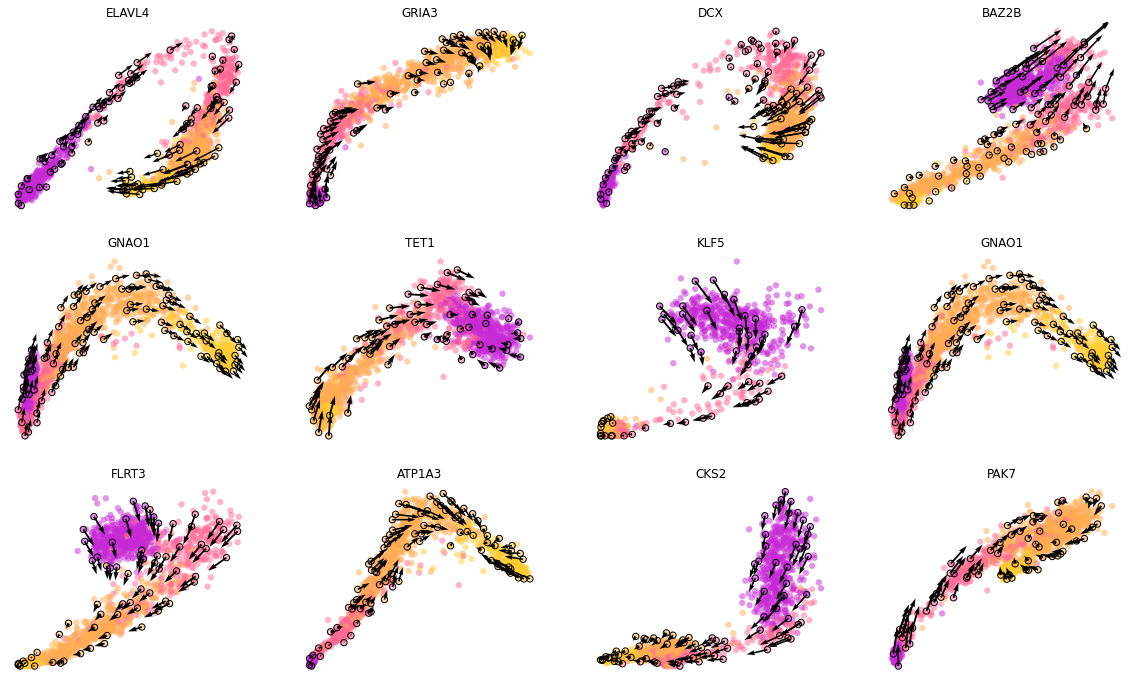

In [5]:
ncols=4
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_hgforebrainglut,
        alpha=0.5, 
        s = 40,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

#plt.show()
plt.savefig('figure/gene_velocity.pdf')

## Project the RNA velocity to vector fields in the embedding space

The projection of RNA velocity in the embedding space could be calculated with ```cd.compute_cell_velocity()```. If not specified, all genes in cellDancer_df will be used to calculate the projection of RNA velocity in the embedding space. We project the velocity vectors of the cells into the low-dimensional embedding space following the method of [velocyto](https://velocyto.org/velocyto.py/index.html#) and [scVelo](https://scvelo.readthedocs.io/).

After the calculation, the projected direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.scatter_cell()``` could be used to display the predicted direction in embedding space.

In [6]:
# compute cell velocity
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df,
                                       projection_neighbor_choice='embedding', 
                                       expression_scale='power10', 
                                       #speed_up=None,
                                       projection_neighbor_size=100)

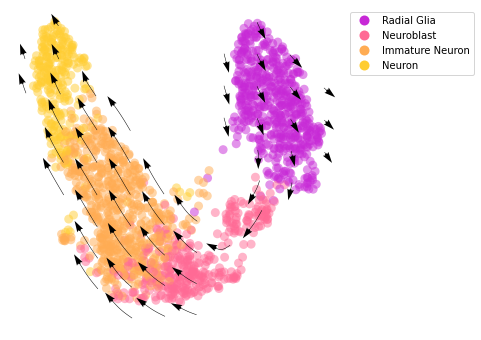

In [7]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(6,6))

cdplt.scatter_cell(ax,
                   cellDancer_df,
                   colors=colormap.colormap_hgforebrainglut,
                   alpha=0.5,
                   s=80,
                   velocity=True,
                   legend='on',
                   min_mass=7,
                   arrow_grid=(10,10),
                   legend_marker_size=10)
ax.axis('off')
#plt.show()
plt.savefig('figure/cell_velocity_s.pdf')

### Comparation with embedding information of spliced and unspliced reads

We also use unsplied and spliced reads as embedding information to predict velocity. It is shown that the embedding and the velocity are similar to each other.

To project the prediction of RNA velocity to vector fields in embedding space and to estimate pseudotime by using all genes, all the 1,054 genes have already been predicted and could be downloaded and unzipped [HgForebrainGlut_cellDancer_estimation_unspliced_spliced.csv.zip](https://drive.google.com/file/d/TBD). The csv file could be loaded by ```pd.read_csv()```.

In [8]:
# load the prediction result of all genes
cellDancer_df_u_s_file = 'data/HgForebrainGlut_cellDancer_estimation_unspliced_spliced.csv'
cellDancer_df_u_s=pd.read_csv(cellDancer_df_u_s_file)

In [9]:
cellDancer_df_u_s

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,SCAPER,0.377907,0.300250,0.405763,0.312984,0.272667,0.574098,0.637763,0.067002,10X_17_028:AACCATGGTAATCACCx,Neuroblast,-0.089552,1.610141,0,-0.238766,-0.097604
1,1,SCAPER,0.346111,0.307946,0.376842,0.309154,0.260747,0.575780,0.639291,0.067002,10X_17_028:AACCATGCATACTACGx,Neuroblast,0.177206,1.852133,1,-0.223590,-0.037993
2,2,SCAPER,0.377427,0.157733,0.425090,0.214923,0.307992,0.563463,0.623120,0.067002,10X_17_028:AAACCTGGTAAAGGAGx,Radial Glia,7.815600,5.937497,2,-0.070768,-0.119006
3,3,SCAPER,0.450290,0.237188,0.478714,0.290154,0.312150,0.566972,0.629754,0.067002,10X_17_028:AAAGTAGCAAAGTCAAx,Radial Glia,6.701630,8.941791,3,0.128211,-0.279892
4,4,SCAPER,0.405460,0.349812,0.423425,0.354449,0.269818,0.576849,0.642101,0.067002,10X_17_028:AAAGCAACAAACGCGAx,Neuroblast,-1.126250,1.166313,4,-0.442851,0.011849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812875,1715,PCP4,0.000000,0.017668,0.000006,0.017446,0.000013,0.214343,0.025120,0.055841,10X_17_029:TTTATGCGTTGCGCACx,Radial Glia,5.943436,7.754985,1715,0.111940,-0.211817
1812876,1716,PCP4,0.000000,0.012055,0.000007,0.011903,0.000013,0.214868,0.025108,0.055841,10X_17_029:TTTGCGCGTTCCGTCTx,Neuroblast,-2.248025,0.979071,1716,-0.420666,-0.064146
1812877,1717,PCP4,0.004955,0.156260,0.004458,0.154778,0.000007,0.202196,0.025381,0.055841,10X_17_029:TTTGGTTGTACCCAATx,Neuron,-8.651434,4.843134,1717,-0.162622,0.434658
1812878,1718,PCP4,0.000000,0.014440,0.000006,0.014259,0.000013,0.214645,0.025113,0.055841,10X_17_029:TTTCCTCCAGTCCTTCx,Radial Glia,7.854761,8.556604,1718,0.107540,-0.174899


In [10]:
# compute cell velocity
cellDancer_df_u_s=cd.compute_cell_velocity(cellDancer_df=cellDancer_df_u_s,
                                       projection_neighbor_choice='embedding', 
                                       expression_scale='power10', 
                                       #speed_up=None,
                                       projection_neighbor_size=100)

Caution! Overwriting the 'velocity' columns.


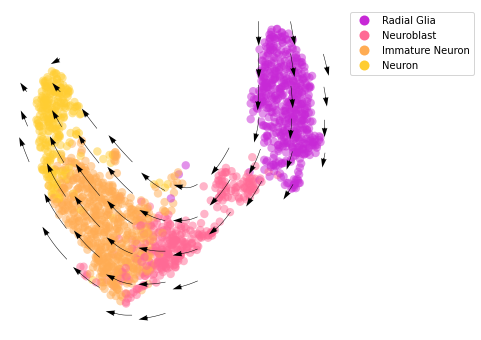

In [11]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(6,6))

cdplt.scatter_cell(ax,
                   cellDancer_df_u_s,
                   colors=colormap.colormap_hgforebrainglut,
                   alpha=0.5,
                   s=70,
                   velocity=True,
                   legend='on',
                   min_mass=15,
                   arrow_grid=(10,10),
                   legend_marker_size=10)
ax.axis('off')
#plt.show()
plt.savefig('figure/cell_velocity_u_s.pdf')

## Estimate pseudotime

Based on the projection of RNA velocity in embedding space, the pseudotime could be estimated with ```cd.pseudo_time()```.

In [12]:
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 3,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               activate_umap_paths_divider=False,
                               #plot_rep_trajs = False,
                               n_jobs=8)

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|█████████████| 7260/7260 [00:08<00:00, 887.87it/s]


There are 3 clusters.
[0 1 2]
--- 17.52203106880188 seconds ---


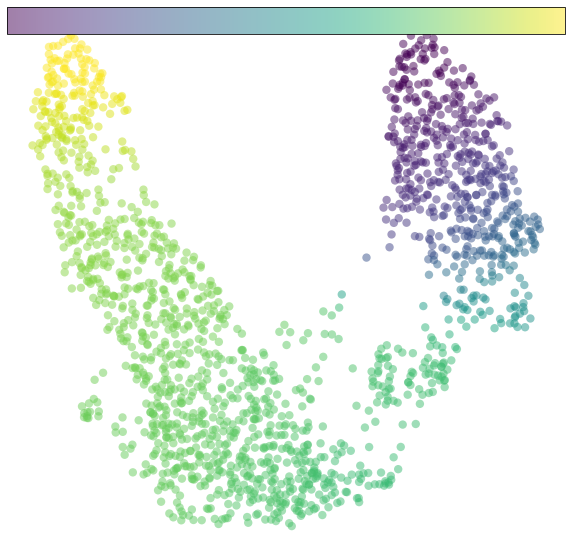

<Figure size 432x288 with 0 Axes>

In [13]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(10,10))
im=cdplt.scatter_cell(ax,cellDancer_df, 
                      colors='pseudotime', 
                      alpha=0.5, 
                      s=70,
                      velocity=False, 
                      colorbar='on'
                     )
ax.axis('off')
plt.show()
plt.savefig('figure/pseudotime.pdf')